##### Copyright 2020 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
#@title License header
# Copyright 2020 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# MNIST Model TensorFlow Training, IREE Execution

## Overview

This notebook creates and trains a TensorFlow 2.0 model for recognizing handwritten digits using the [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database), then compiles and executes that trained model using IREE.

In [2]:
!python -m pip install iree-compiler-snapshot iree-runtime-snapshot iree-tools-tf-snapshot -f https://github.com/google/iree/releases

Looking in links: https://github.com/google/iree/releases
     |████████████████████████████████| 27.9MB 154kB/s 
     |████████████████████████████████| 1.0MB 56.9MB/s 
     |████████████████████████████████| 41.4MB 85kB/s 


In [3]:
#@title Imports and Setup

from pyiree import rt as ireert
from pyiree.tf.support import module_utils
from pyiree.compiler2 import tf as tfc

from matplotlib import pyplot as plt
import numpy as np
import os
import tempfile
import tensorflow as tf

ARTIFACTS_DIR = os.path.join(tempfile.gettempdir(), 'iree', 'modules')
print("Artifacts directory is: ", ARTIFACTS_DIR)

plt.style.use("seaborn-whitegrid")
plt.rcParams["font.family"] = "monospace"

# Print version information for future notebook users to reference.
print("TensorFlow version: ", tf.__version__)
print("Numpy version: ", np.__version__)

# (Temporary) workaround for absl flags...
# https://github.com/googlecolab/colabtools/issues/1323#issuecomment-756343620
import sys
from absl import app
sys.argv = sys.argv[:1]
try:
  app.run(lambda argv: None)
except:
  pass

Artifacts directory is:  /tmp/iree/modules
TensorFlow version:  2.4.0
Numpy version:  1.19.4


# Create and Train MNIST Model in TensorFlow

The specific details of the training process here aren't critical to the model compilation and execution through IREE.

11493376/11490434 [==============================] - 0s 0us/step
Sample image from the dataset:


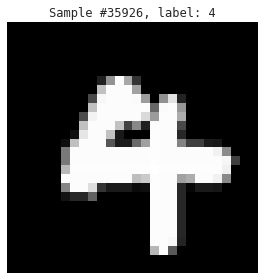

In [4]:
#@title Load MNIST dataset, setup training and evaluation

# Keras datasets don't provide metadata.
NUM_CLASSES = 10
NUM_ROWS, NUM_COLS = 28, 28

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Reshape into grayscale images:
x_train = np.reshape(x_train, (-1, NUM_ROWS, NUM_COLS, 1))
x_test = np.reshape(x_test, (-1, NUM_ROWS, NUM_COLS, 1))

# Rescale uint8 pixel values into floats:
x_train = x_train / 255
x_test = x_test / 255

# Explicitly cast to float32 because numpy defaults to double precision and
# IREE uses single precision:
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

print("Sample image from the dataset:")
sample_index = np.random.randint(x_train.shape[0])
plt.imshow(x_train[sample_index].reshape(NUM_ROWS, NUM_COLS), cmap="gray")
plt.title(f"Sample #{sample_index}, label: {y_train[sample_index]}")
plt.axis("off")
plt.tight_layout()

In [5]:
#@title Define a DNN model using tf.keras API

def simple_dnn(num_classes):
  """Creates a simple multi-layer perceptron model."""

  model = tf.keras.models.Sequential()
  # Flatten to a 1d array (e.g. 28x28x1 -> 784).
  model.add(tf.keras.layers.Flatten())
  # Fully-connected neural layer with 128 neurons, RELU activation.
  model.add(tf.keras.layers.Dense(128, activation="relu"))
  # Fully-connected neural layer returning probability scores for each class.
  model.add(tf.keras.layers.Dense(num_classes, activation="softmax"))
  return model

In [6]:
#@markdown ### Training Parameters

batch_size = 32  #@param { type: "slider", min: 10, max: 400 }
num_epochs = 8    #@param { type: "slider", min:  1, max:  20 }

In [7]:
#@title Train the Keras model

tf_model = simple_dnn(NUM_CLASSES)
# Stateful optimizers like Adam create variable incompatible with compilation as
# currently implemented.
tf_model.compile(
    optimizer="sgd", loss="sparse_categorical_crossentropy", metrics="accuracy")
tf_model.fit(x_train, y_train, batch_size, num_epochs, validation_split=0.1)

Epoch 1/8
1688/1688 [==============================] - 4s 2ms/step - loss: 1.1068 - accuracy: 0.7158 - val_loss: 0.3270 - val_accuracy: 0.9142
Epoch 2/8
1688/1688 [==============================] - 3s 2ms/step - loss: 0.3705 - accuracy: 0.8982 - val_loss: 0.2648 - val_accuracy: 0.9288
Epoch 3/8
1688/1688 [==============================] - 3s 2ms/step - loss: 0.3143 - accuracy: 0.9133 - val_loss: 0.2326 - val_accuracy: 0.9397
Epoch 4/8
1688/1688 [==============================] - 3s 2ms/step - loss: 0.2728 - accuracy: 0.9236 - val_loss: 0.2127 - val_accuracy: 0.9440
Epoch 5/8
1688/1688 [==============================] - 3s 2ms/step - loss: 0.2529 - accuracy: 0.9294 - val_loss: 0.1982 - val_accuracy: 0.9477
Epoch 6/8
1688/1688 [==============================] - 3s 2ms/step - loss: 0.2327 - accuracy: 0.9347 - val_loss: 0.1853 - val_accuracy: 0.9523
Epoch 7/8
1688/1688 [==============================] - 3s 2ms/step - loss: 0.2141 - accuracy: 0.9403 - val_loss: 0.1720 - val_accuracy: 0.9572

# Compile and Execute MNIST Model using IREE

In [8]:
#@title Wrap the model in a tf.Module with IREE-compatible settings and convert to MLIR.

# Since the model was written in sequential style, explicitly wrap in a module.
inference_module = tf.Module()
inference_module.model = tf_model

# Hack: Convert to static shape. Won't be necessary once dynamic shapes are in.
input_shape = list(tf_model.inputs[0].shape)
input_shape[0] = 1  # Make fixed (batch=1)

# Produce a concrete function to compile.
inference_module.predict = tf.function(input_signature=[
    tf.TensorSpec(input_shape, tf_model.inputs[0].dtype)
])(lambda x: tf_model.call(x, training=False))

# Only try to compile the function we care about:
exported_names = ["predict"]

In [9]:
#@markdown ### Backend Configuration

backend_choice = "iree_vmla (CPU)" #@param [ "iree_vmla (CPU)", "iree_llvmaot (CPU)", "iree_vulkan (GPU/SwiftShader)" ]
backend_choice = backend_choice.split(" ")[0]
backend = module_utils.BackendInfo(backend_choice)

In [10]:
#@title Compile the mhlo MLIR to an IREE backend and prepare a context to execute it

iree_module = module_utils.IreeCompiledModule.create_from_instance(
    inference_module, backend, exported_names, ARTIFACTS_DIR)

print("* Module compiled! See intermediate .mlir files in", ARTIFACTS_DIR, "*")

I0107 21:49:35.160961 140429953972096 module_utils.py:88] Outputting intermediate artifacts (--artifacts_dir is set):
  output_file: /tmp/iree/modules/iree_vmla/compiled.vmfb
  saved_model_dir: /tmp/iree/modules/tfmodule.saved_model
  save_temp_tf_input: /tmp/iree/modules/tf_input.mlir
  save_temp_iree_input: /tmp/iree/modules/iree_input.mlir
  crash_reproducer_path: /tmp/iree/modules/reproducer__iree_vmla.mlir


INFO:tensorflow:Assets written to: /tmp/iree/modules/tfmodule.saved_model/assets


I0107 21:49:35.632078 140429953972096 builder_impl.py:775] Assets written to: /tmp/iree/modules/tfmodule.saved_model/assets


* Module compiled! See intermediate .mlir files in /tmp/iree/modules *


2021-01-07 21:49:35.767974: I external/org_tensorflow/tensorflow/cc/saved_model/bundle_v2.cc:32] Reading SavedModel from: /tmp/iree/modules/tfmodule.saved_model
2021-01-07 21:49:35.768968: I external/org_tensorflow/tensorflow/cc/saved_model/bundle_v2.cc:55] Reading SavedModel debug info (if present) from: /tmp/iree/modules/tfmodule.saved_model
Created IREE driver vmla: <pyiree.rt.binding.HalDriver object at 0x7fb803d9d2d0>
SystemContext driver=<pyiree.rt.binding.HalDriver object at 0x7fb803d9d2d0>


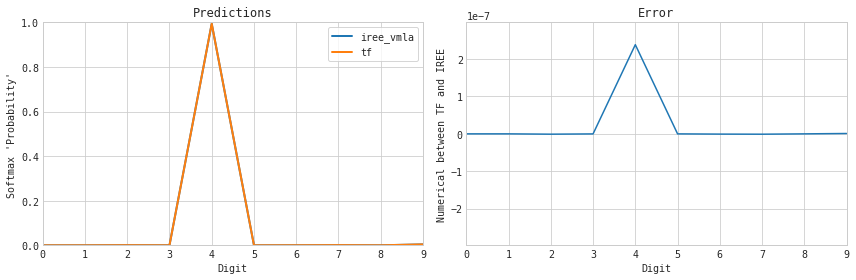

In [11]:
#@title Execute the compiled module and compare the results with TensorFlow

# Invoke the 'predict' function with a single image as an argument
iree_prediction = iree_module.predict(x_train[sample_index][None, :])[0]
tf_prediction = tf_model.predict(x_train[sample_index][None, :])[0]
error = tf_prediction - iree_prediction

fig, axs = plt.subplots(1, 2)
fig.set_figwidth(12)

ax = axs[0]
ax.plot(iree_prediction, linewidth=2, label=backend.backend_name)
ax.plot(tf_prediction, linewidth=2, label="tf")

ax.set_title("Predictions")
ax.set_ylabel("Softmax 'Probability'")
ax.set_xlabel("Digit")
ax.set_ylim(0, 1)
ax.set_xlim(0, 9)
ax.legend(frameon=True)

ax = axs[1]
ax.plot(error)

ax.set_title("Error")
ax.set_ylabel("Numerical between TF and IREE")
ax.set_xlabel("Digit")
ylim = 1.25 * np.max(np.abs(error))
ax.set_ylim(-ylim, ylim)
ax.set_xlim(0, 9)

fig.tight_layout()